In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

In [39]:
# Import helper functions
sys.path.append('..')
from src.analysis_utils import *

# Configuration
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100

In [134]:
from importlib import reload
from src import analysis_utils

reload(analysis_utils)
from src.analysis_utils import *

In [4]:
# File paths
DATA_DIR = Path("../data/")
DEAM_CORE_PATH = DATA_DIR / "processed/core_dataset.parquet"
DEAM_CORE_PATH_LYRICS = DATA_DIR / "processed/DEAM/old/core_dataset_lyrics.parquet"
LYRICS_CACHE_PATH = DATA_DIR / "processed/DEAM/lyrics_cache.json"
DF_MUSICAL_PATH = DATA_DIR / "processed/derived/exp2_full_3900/musical_level.parquet"
DF_PERCEPTUAL_PATH = DATA_DIR / "processed/derived/exp2_full_3900/perceptual_level.parquet"
DF_LOW_PATH = DATA_DIR / "processed/derived/exp2_full_3900/low_level_selected.parquet"
MUSIC_METADATA_PATH = Path("../data/processed/audio_metadata.parquet")

FEATURES_PATH = Path("../data/raw/features")
VIZ_PATH = Path("../results/plots/data_quality_DEAM")
VIZ_PATH.mkdir(parents=True, exist_ok=True)

### DATA LOADING AND BASIC STATISTICS

In [5]:
df_low = pd.read_parquet(DF_LOW_PATH)
df_core = pd.read_parquet(DEAM_CORE_PATH)
df_music_basic = pd.read_parquet(DF_MUSICAL_PATH)
df_percept_basic = pd.read_parquet(DF_PERCEPTUAL_PATH)
metadata_df = pd.read_parquet(MUSIC_METADATA_PATH)

In [6]:
df_core.set_index('song_id')
labels_df = df_core[['valence_mean', 'arousal_mean']]
df_percept = labels_df.merge(
    df_percept_basic,
    left_index=True,
    right_index=True)
df_music = labels_df.merge(
    df_music_basic,
    left_index=True,
    right_index=True)

In [7]:
df_percept.head(2)

valence_mean  arousal_mean  articulation   dissonance  melodiousness  \
2           5.7           5.5      1.434269  63590.84980       1.007936   
3           4.4           5.3      0.564043  12913.57189       1.021960   

   rhythmic_complexity  rhythmic_stability  tonal_stability  minorness  
2             0.040871            0.868260        50.744050   0.259305  
3             0.037812            0.606978        12.029556   0.706457

In [8]:
# Create combined dataframe 1: Perceptual features + BPM/Key/Mode
df_percept_combined = df_percept.merge(
    metadata_df.set_index('song_id')[['key', 'mode', 'key_confidence', 'bpm']], 
    left_index=True, 
    right_index=True, 
    how='inner'
)

# Create combined dataframe 2: Musical features + BPM/Key/Mode  
df_music_combined = df_music.merge(
    metadata_df.set_index('song_id')[['key', 'mode', 'key_confidence', 'bpm']], 
    left_index=True, 
    right_index=True, 
    how='inner'
)

In [9]:
# Add the key_mode derived feature that your functions expect
df_percept_combined['key_mode'] = df_percept_combined['key'].astype(str) + '_' + df_percept_combined['mode'].astype(str)
df_music_combined['key_mode'] = df_music_combined['key'].astype(str) + '_' + df_music_combined['mode'].astype(str)

# Verify the merges
print(f"Perceptual combined: {len(df_percept_combined)} records")
print(f"Columns: {list(df_percept_combined.columns)}")
print()
print(f"Musical combined: {len(df_music_combined)} records") 
print(f"Columns: {list(df_music_combined.columns)}")

Perceptual combined: 1545 records
Columns: ['valence_mean', 'arousal_mean', 'articulation', 'dissonance', 'melodiousness', 'rhythmic_complexity', 'rhythmic_stability', 'tonal_stability', 'minorness', 'key', 'mode', 'key_confidence', 'bpm', 'key_mode']

Musical combined: 1545 records
Columns: ['valence_mean', 'arousal_mean', 'timbre', 'rhythm', 'brightness', 'voice_quality', 'harmony', 'voice', 'spectral', 'dynamics', 'minorness', 'key', 'mode', 'key_confidence', 'bpm', 'key_mode']


In [10]:
# Load core dataset with lyrics
df_core_lyrics = pd.read_parquet(DEAM_CORE_PATH_LYRICS)

print(f"Dataset shape: {df_core_lyrics.shape}")
print(f"Columns: {list(df_core_lyrics.columns)}")
print(f"\nFirst 5 rows:")
print(df_core_lyrics.head())

print(f"\nDataset info:")
print(df_core_lyrics.info())

Dataset shape: (1802, 8)
Columns: ['song_id', 'track_name', 'artist_name', 'valence_mean', 'arousal_mean', 'valence_std', 'arousal_std', 'lyrics']

First 5 rows:
   song_id                 track_name                   artist_name  \
0        2  Tonight  A Lonely Century  The New Mystikal Troubadours   
1        3                  DD Groove                 Kevin MacLeod   
2        4                  Slow Burn                 Kevin MacLeod   
3        5               Nothing Much                 My Bubba & Mi   
4        7                     Hustle                 Kevin MacLeod   

   valence_mean  arousal_mean  valence_std  arousal_std lyrics  
0           3.1           3.0         0.94         0.63   None  
1           3.5           3.3         1.75         1.62   None  
2           5.7           5.5         1.42         1.63   None  
3           4.4           5.3         2.01         1.85   None  
4           5.8           6.4         1.47         1.69   None  

Dataset info:
<class

In [11]:
# Load lyrics cache for comparison
import json
with open(LYRICS_CACHE_PATH, 'r', encoding='utf-8') as f:
    lyrics_cache = json.load(f)

# Lyrics statistics
csv_valid_lyrics = df_core_lyrics['lyrics'].apply(lambda x: isinstance(x, str) and x.strip() != "").sum()
json_valid_lyrics = sum(isinstance(v, str) and v.strip() != "" for v in lyrics_cache.values())

print("Lyrics availability:")
print(f"Valid lyrics in CSV: {csv_valid_lyrics}")
print(f"Valid lyrics in cache: {json_valid_lyrics}")

Lyrics availability:
Valid lyrics in CSV: 241
Valid lyrics in cache: 241


In [13]:
# Basic emotion statistics
emotion_cols = ['valence_mean', 'valence_std', 'arousal_mean', 'arousal_std']
print(f"\nEmotion metrics summary:")
print(df_core[emotion_cols].describe())


Emotion metrics summary:
       valence_mean  valence_std  arousal_mean  arousal_std
count   1802.000000  1802.000000   1802.000000  1802.000000
mean       4.904145     1.502364      4.814029     1.462719
std        1.174240     0.400181      1.282187     0.370658
min        1.600000     0.300000      1.600000     0.370000
25%        4.100000     1.220000      3.800000     1.200000
50%        4.900000     1.500000      4.900000     1.480000
75%        5.800000     1.760000      5.800000     1.720000
max        8.400000     2.900000      8.100000     2.590000


In [14]:
# Quick statistical overview
print(f"\nValence/Arousal ranges:")
for col in ['valence_mean', 'arousal_mean']:
    values = df_core[col].dropna()
    print(f"  {col}: {values.min():.2f} to {values.max():.2f} "
          f"(mean: {values.mean():.2f}, std: {values.std():.2f})")


Valence/Arousal ranges:
  valence_mean: 1.60 to 8.40 (mean: 4.90, std: 1.17)
  arousal_mean: 1.60 to 8.10 (mean: 4.81, std: 1.28)


### EMOTION DISTRIBUTION ANALYSIS

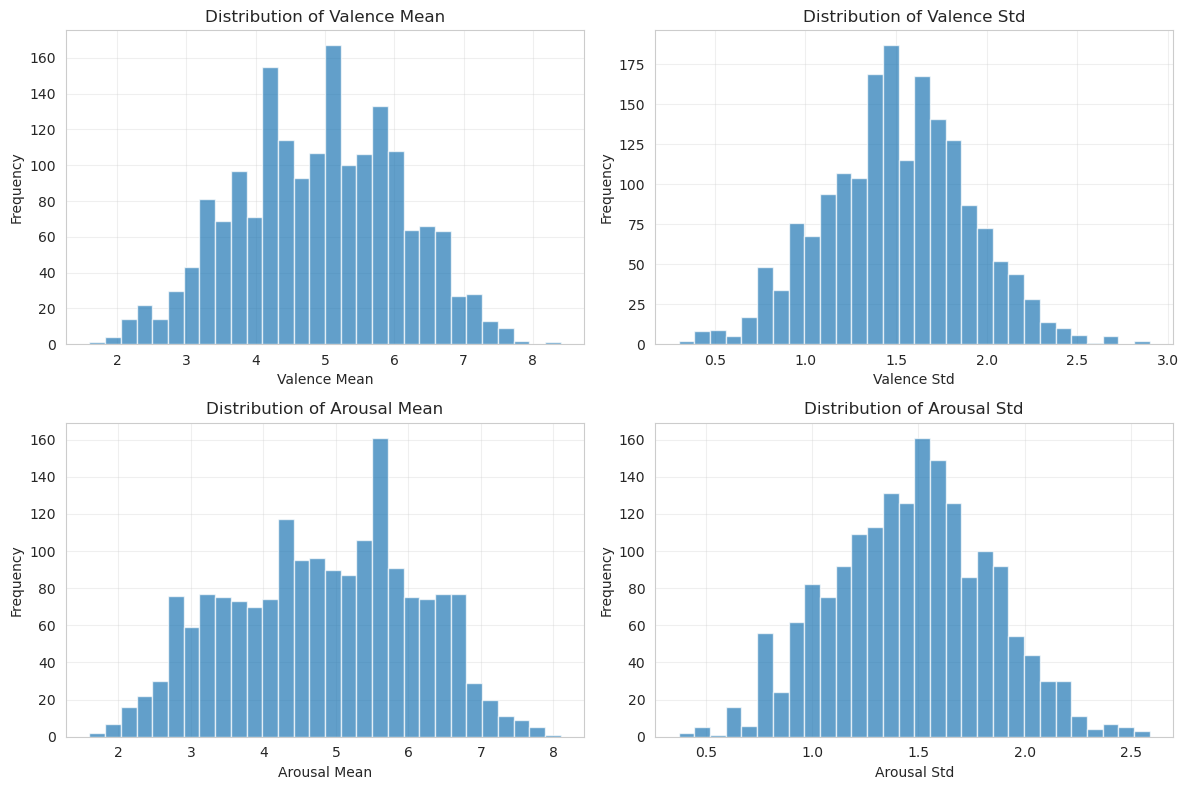

In [15]:
# Plot emotion distributions
plot_emotion_distributions(df_core, VIZ_PATH)

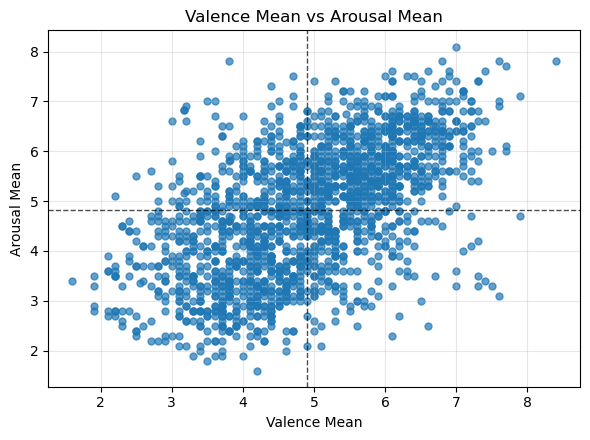

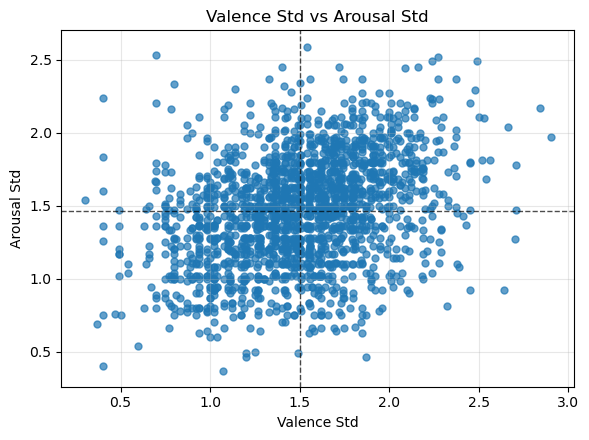

In [40]:
# Scatter plots for emotion relationships
plot_emotion_scatter(df_core, VIZ_PATH, 'mean')
plot_emotion_scatter(df_core, VIZ_PATH, 'std')

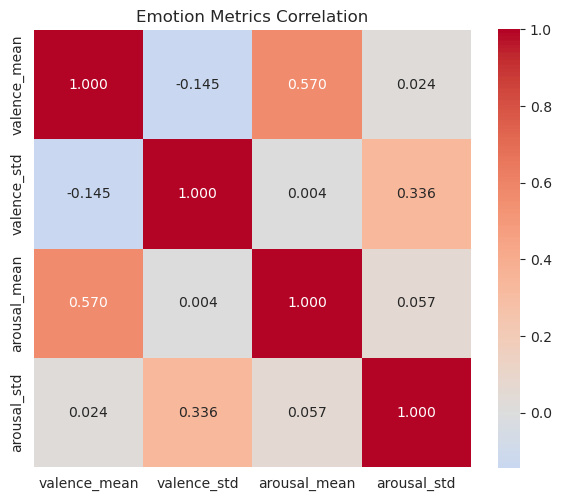

In [17]:
# Emotion correlation
emotion_corr = df_core[emotion_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(emotion_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')

plt.title('Emotion Metrics Correlation')
plt.tight_layout()
plt.savefig(VIZ_PATH / 'emotion_correlation.png', dpi=150)
plt.show()

High correlation (0.57) between valence and arousal. Inner annotator aggreement (std) also moderately correlated for valence and arousal.

### Data Validation

Check the raw data's variability in duration before aggregating it into statistical features: If there is no variability, then the validity of extracting temporal carrying information from the statistical descriptors is not guaranteed.

In [18]:
# Analyze row distribution
print("Analyzing row distribution across all songs...")
stats, row_counts = analyze_raw_data_distribution(FEATURES_PATH)

print(f"\nOverall Statistics (rows per song):")
print(f"  Mean: {stats['row_stats']['mean']:.1f} ± {stats['row_stats']['std']:.1f}")
print(f"  Min: {stats['row_stats']['min']:.0f}")
print(f"  Max: {stats['row_stats']['max']:.0f}")
print(f"  Q25-Q75: {stats['row_stats']['q25']:.0f} - {stats['row_stats']['q75']:.0f}")

print(f"\nDistribution by threshold:")
for threshold, data in stats['row_distribution'].items():
    print(f"  Songs with {threshold}: {data['count']} ({data['percentage']:.1f}%)")

Analyzing row distribution across all songs...
Analyzing 1802 CSV files...


Counting rows:   0%|          | 0/1802 [00:00<?, ?it/s]


Overall Statistics (rows per song):
  Mean: 254.0 ± 230.4
  Min: 88
  Max: 1253
  Q25-Q75: 88 - 405

Distribution by threshold:
  Songs with above_90: 801 (44.5%)
  Songs with above_92: 801 (44.5%)
  Songs with above_100: 796 (44.2%)
  Songs with above_300: 618 (34.3%)
  Songs with above_400: 457 (25.4%)


In [19]:
print(f"\nTrain vs Test comparison:")
train_stats = stats['test_vs_train']['train_songs']
test_stats = stats['test_vs_train']['test_songs']
print(f"  Train songs (ID ≤ 2000): {train_stats['count']}")
print(f"    Mean rows: {train_stats['mean_rows']:.1f} ± {train_stats['std_rows']:.1f}")
print(f"    Above 92 rows: {train_stats['above_92']} songs")
print(f"  Test songs (ID > 2000): {test_stats['count']}")
print(f"    Mean rows: {test_stats['mean_rows']:.1f} ± {test_stats['std_rows']:.1f}")
print(f"    Above 92 rows: {test_stats['above_92']} songs")


Train vs Test comparison:
  Train songs (ID ≤ 2000): 1744
    Mean rows: 246.9 ± 227.6
    Above 92 rows: 743 songs
  Test songs (ID > 2000): 58
    Mean rows: 466.4 ± 210.9
    Above 92 rows: 58 songs


Creating visualization...


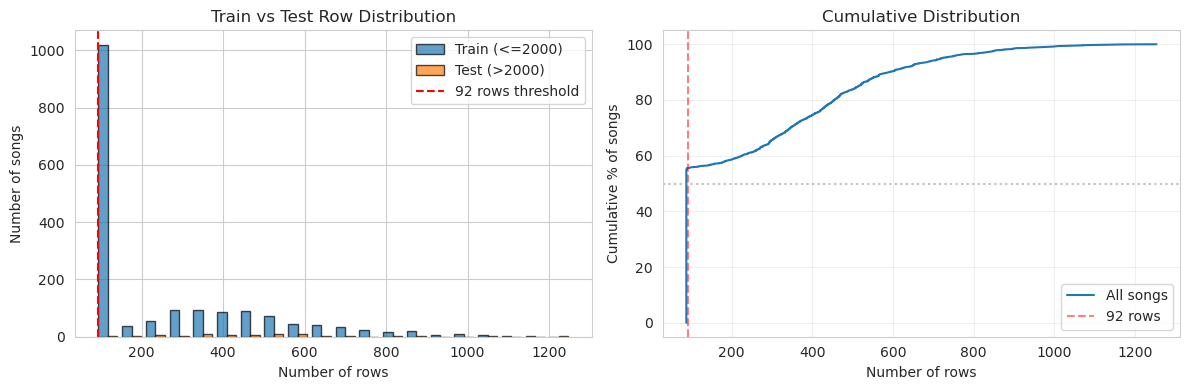

In [33]:
print("Creating visualization...")
visualize_row_distribution(row_counts, VIZ_PATH)

Both train and test songs have varying temporal lengths (varying number of rows)
- train vs test row distributions shows that all test songs have increased row counts from 90 (full length songs), as well as 42% of the songs in the train set
- This variation is actually good for robustness - the model learns from descriptors computed over different time windows - The method of using statistical descriptors is validated as effective, as it doesn't require specific time frame considerations when sampling to get the low level features
- The aggregation functions (mean, std, etc.) naturally handle this variation

### Music Theory feature analysis

### Key/Mode

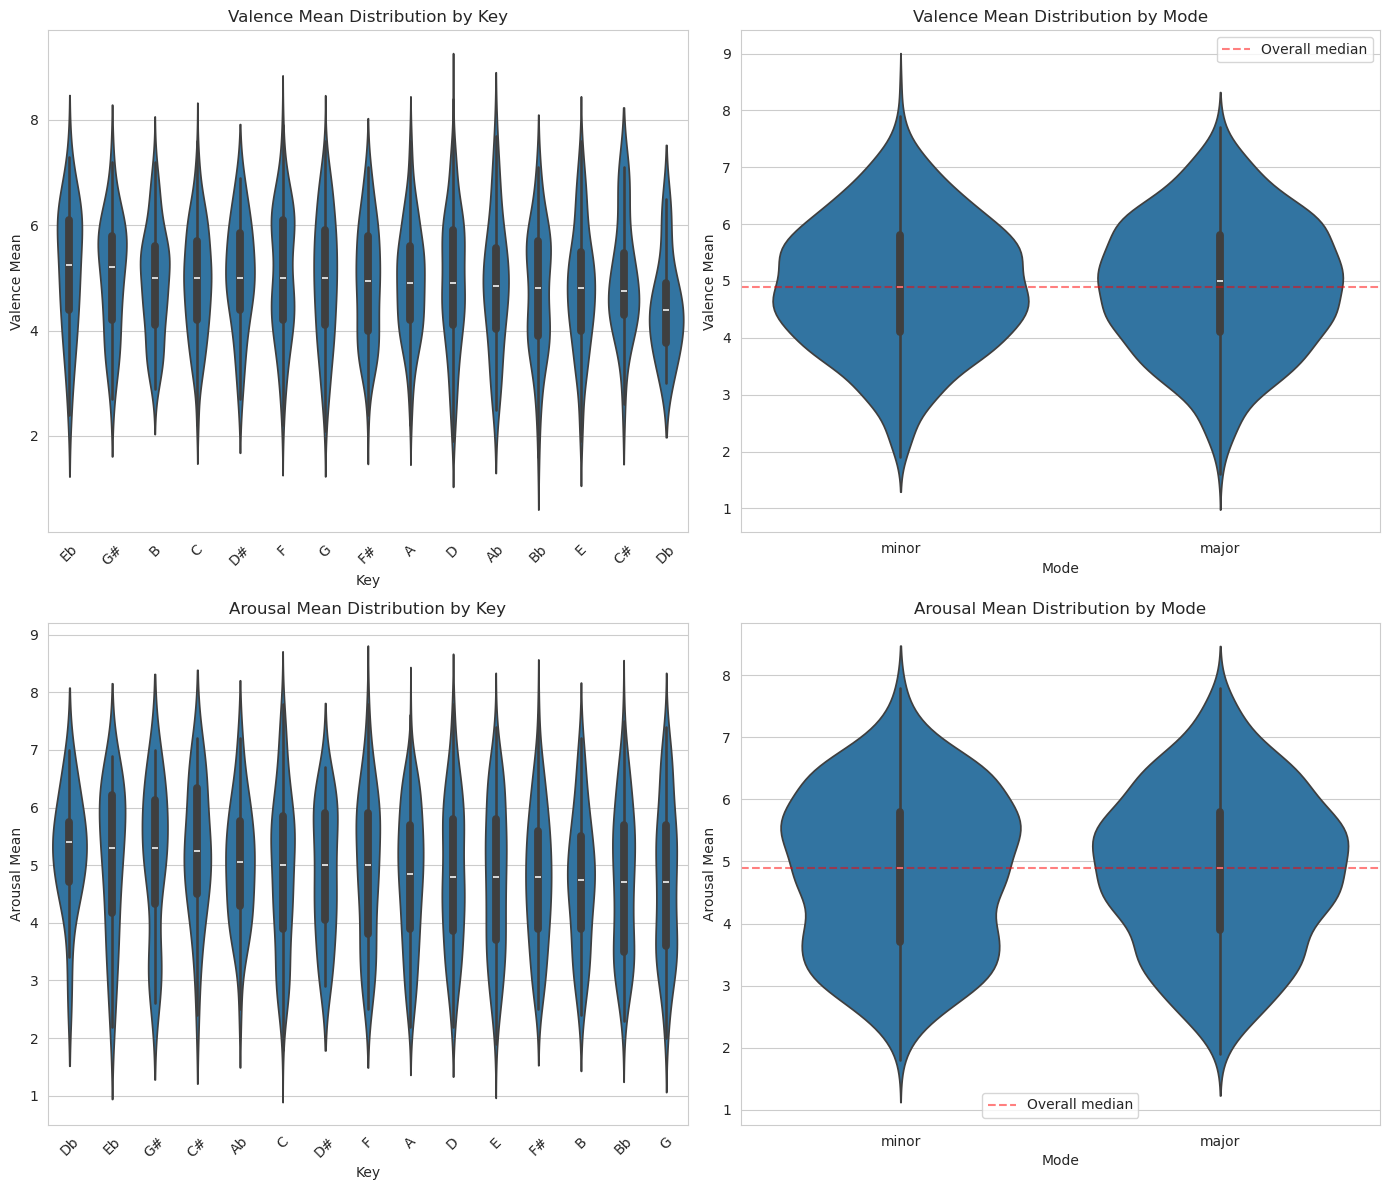

In [34]:
plot_key_mode_distributions(df_percept_combined, VIZ_PATH)

### BPM

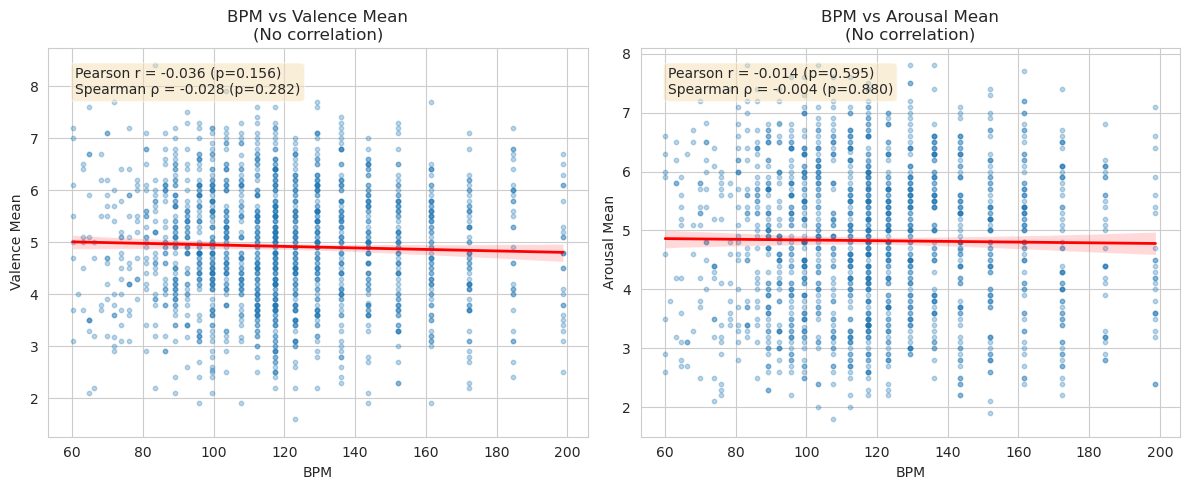

In [35]:
plot_bpm_correlations(df_percept_combined, VIZ_PATH)

### Feature correlations

In [124]:
# Encode categorical variables for correlation analysis
# Perceptual dataframe
df_percept_encoded = df_percept_combined.copy()

# One-hot encode key -chromatic order
key_order = ["key_C", "key_C#", "key_Db", "key_D", "key_D#", "key_Eb",
             "key_E", "key_F", "key_F#", "key_Gb", "key_G", "key_G#",
             "key_Ab", "key_A", "key_Bb", "key_B"]

key_dummies_percept = pd.get_dummies(df_percept_encoded['key'], prefix='key', dtype=int)
key_dummies_percept = key_dummies_percept[[k for k in key_order if k in key_dummies_percept.columns]]

In [125]:
# One-hot encode mode
mode_dummies_percept = pd.get_dummies(df_percept_encoded['mode'], prefix='mode', dtype=int)

# Merge and clean
df_percept_encoded = pd.concat([df_percept_encoded, key_dummies_percept, mode_dummies_percept], axis=1)
df_percept_encoded = df_percept_encoded.drop(columns=['key', 'mode', 'key_mode'], errors='ignore')

In [126]:
# Musical dataframe (same logic, reusing key_order)
df_music_encoded = df_music_combined.copy()
key_dummies_music = pd.get_dummies(df_music_encoded['key'], prefix='key', dtype=int)
key_dummies_music = key_dummies_music[[k for k in key_order if k in key_dummies_music.columns]]

In [127]:
mode_dummies_music = pd.get_dummies(df_music_encoded['mode'], prefix='mode', dtype=int)

df_music_encoded = pd.concat([df_music_encoded, key_dummies_music, mode_dummies_music], axis=1)
df_music_encoded = df_music_encoded.drop(columns=['key', 'mode', 'key_mode'], errors='ignore')

print(f"\nMusical encoded shape: {df_music_encoded.shape}")
print(f"\nMusical encoded shape: {df_percept_encoded.shape}")
print(f"\nMusical encoded shape: {key_dummies_percept.shape}")


Musical encoded shape: (1545, 30)

Musical encoded shape: (1545, 28)

Musical encoded shape: (1545, 15)


In [132]:
df_percept_encoded.head(2)

valence_mean  arousal_mean  articulation   dissonance  melodiousness  \
2           5.7           5.5      1.434269  63590.84980       1.007936   
3           4.4           5.3      0.564043  12913.57189       1.021960   

   rhythmic_complexity  rhythmic_stability  tonal_stability  minorness  \
2             0.040871            0.868260        50.744050   0.259305   
3             0.037812            0.606978        12.029556   0.706457   

   key_confidence  ...  key_F  key_F#  key_G  key_G#  key_Ab  key_A  key_Bb  \
2        0.259305  ...      0       0      0       0       0      1       0   
3        0.706457  ...      0       0      0       0       0      0       0   

   key_B  mode_major  mode_minor  
2      0           0           1  
3      0           0           1  

[2 rows x 28 columns]

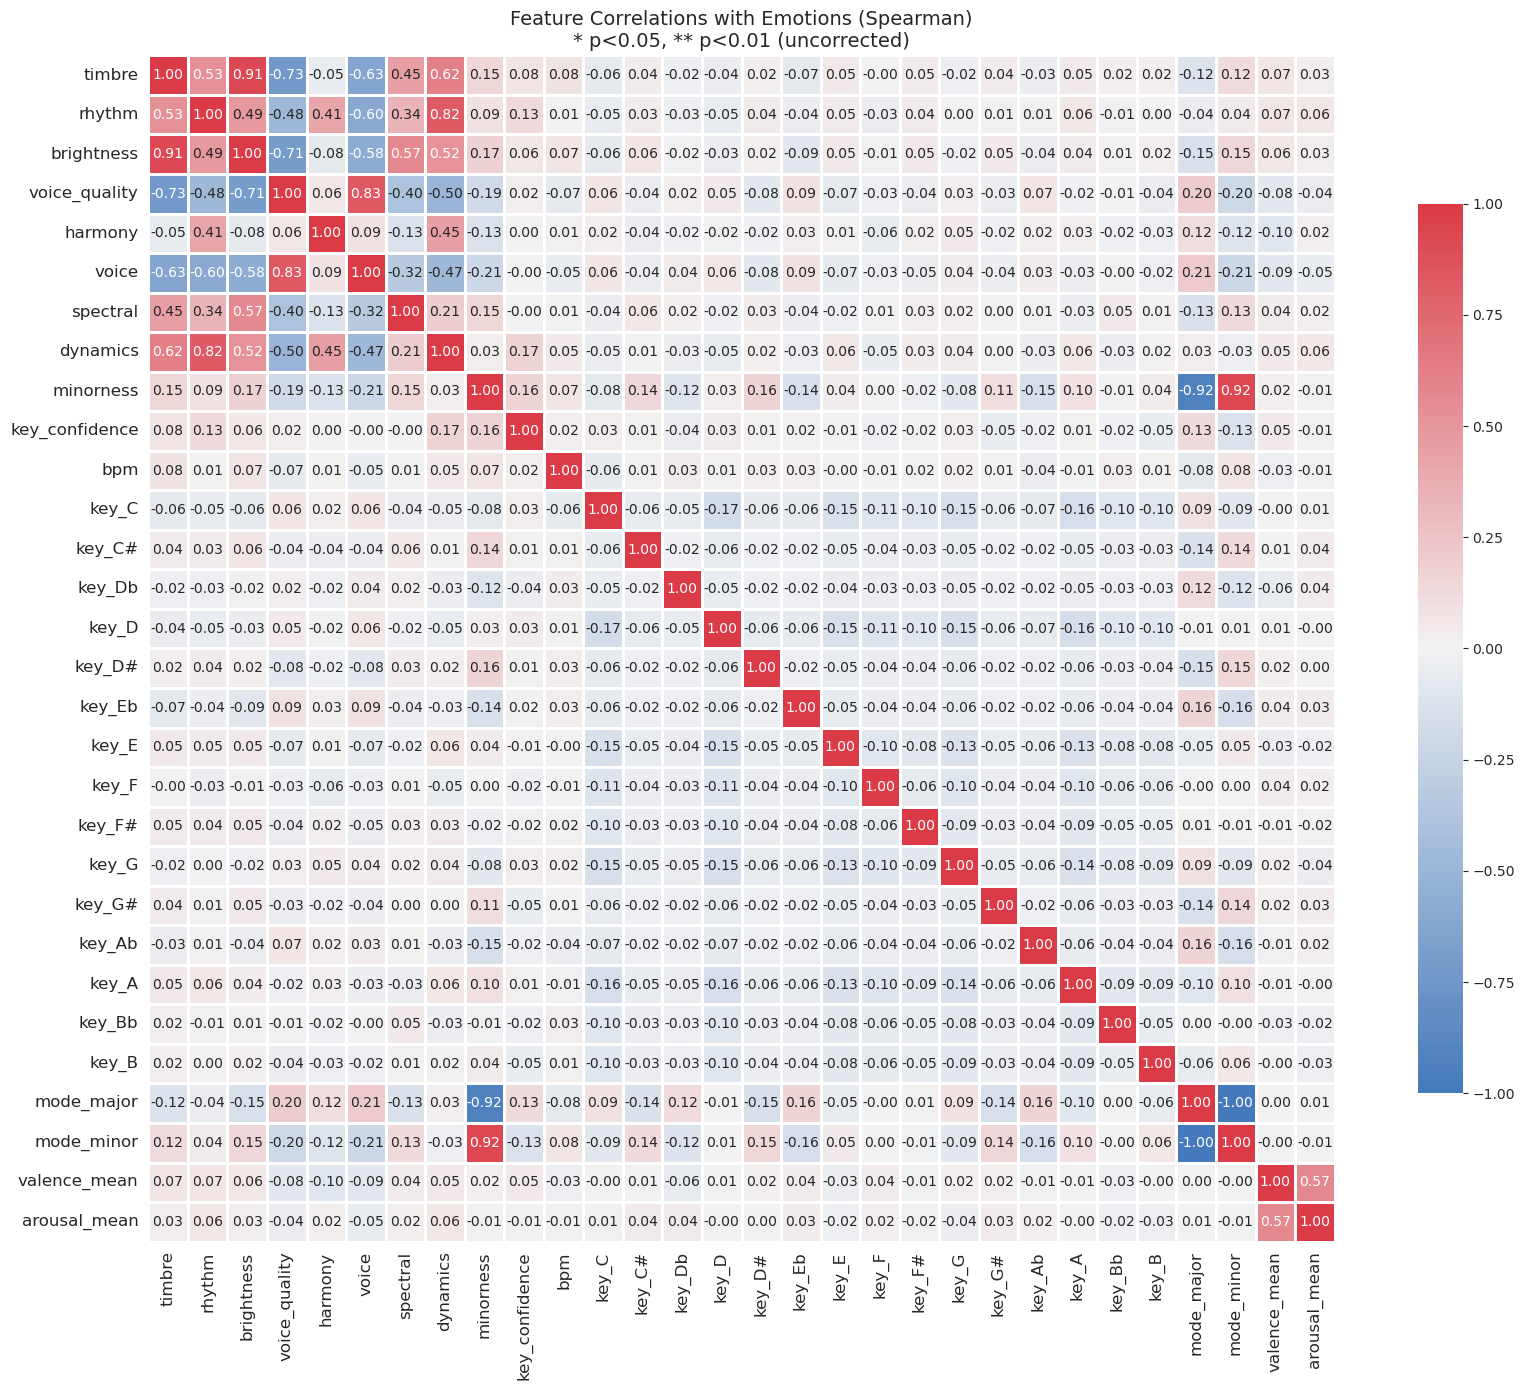


=== Key Findings (uncorrected p-values) ===

Valence Mean:
  - harmony: r=0.101** (weak)
  - voice: r=0.093** (weak)
  - voice_quality: r=0.078** (weak)

Arousal Mean:
  - rhythm: r=0.061* (weak)
  - dynamics: r=0.057* (weak)
  - voice: r=0.054* (weak)


In [135]:
# High-Level Feature correlation heatmap
corr_matrix = plot_feature_correlations_heatmap(df_music_encoded, VIZ_PATH, level = 'high')

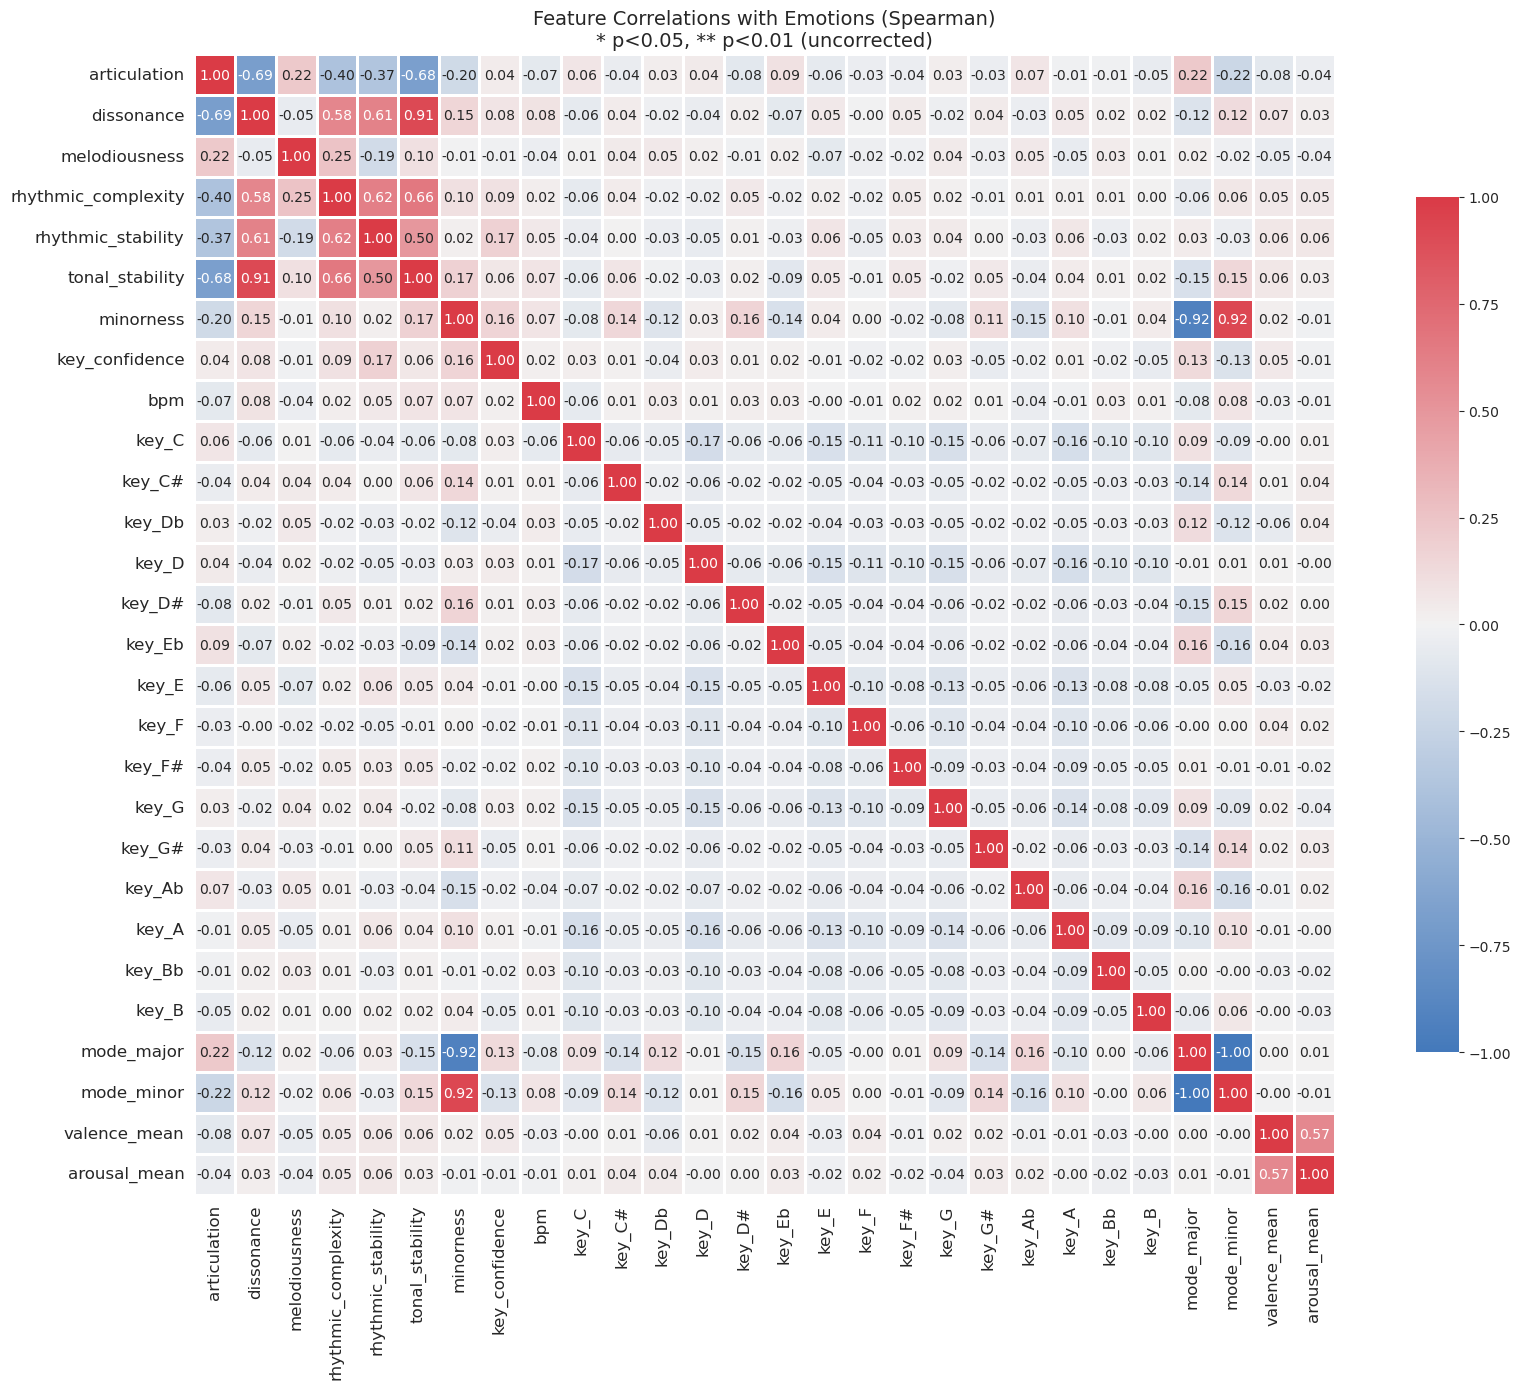


=== Key Findings (uncorrected p-values) ===

Valence Mean:
  - articulation: r=0.082** (weak)
  - dissonance: r=0.065* (weak)
  - tonal_stability: r=0.059* (weak)

Arousal Mean:
  - rhythmic_stability: r=0.057* (weak)
  - rhythmic_complexity: r=0.049 (weak)
  - key_C#: r=0.043 (weak)


In [136]:
# Mid-Level Feature correlation heatmap
corr_matrix_mid = plot_feature_correlations_heatmap(df_percept_encoded, VIZ_PATH, level = 'mid')

In [91]:
df_percept_numeric = df_percept_encoded.drop(columns=[c for c in df_percept_encoded.columns
                                        if 'key' in c or 'mode' in c], errors='ignore')

df_music_numeric = df_music_encoded.drop(columns=[c for c in df_music_encoded.columns
                                        if 'key' in c or 'mode' in c], errors='ignore')

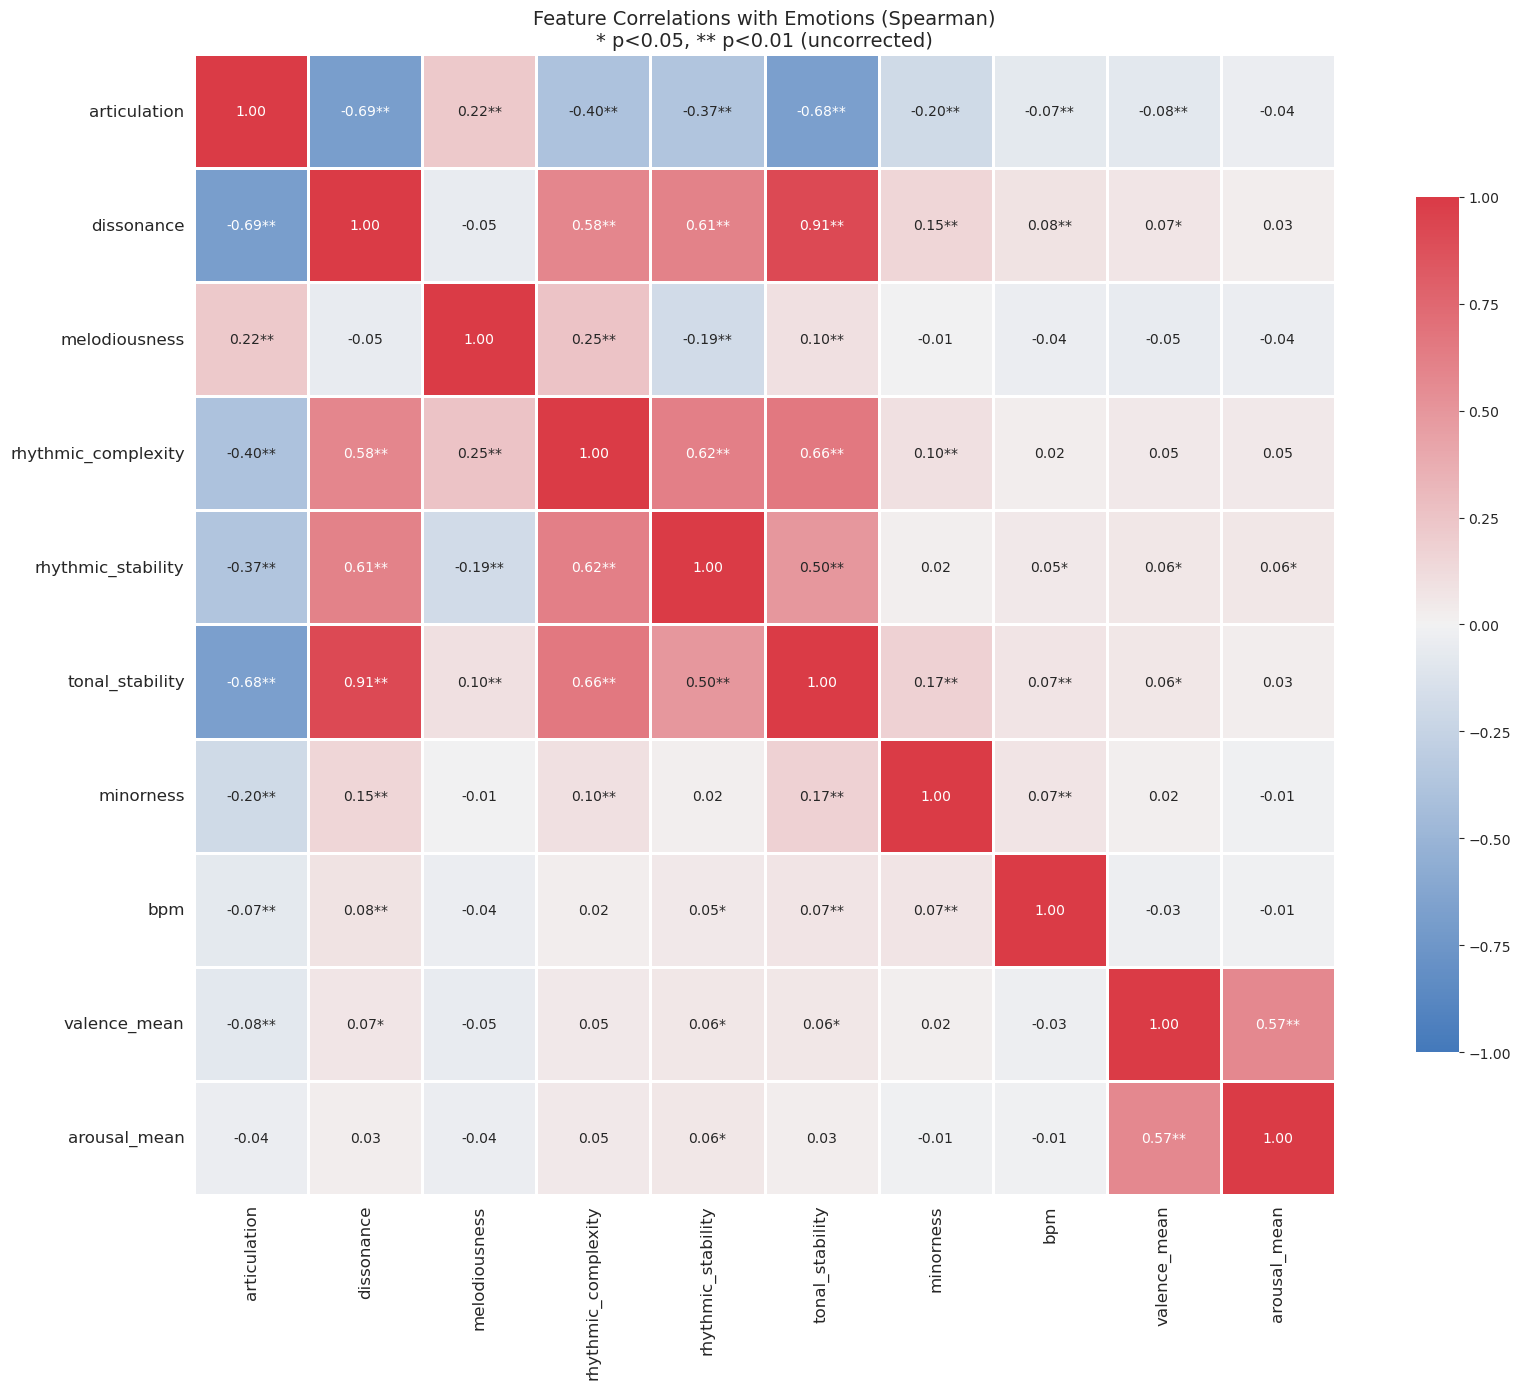


=== Key Findings (uncorrected p-values) ===

Valence Mean:
  - articulation: r=0.082** (weak)
  - dissonance: r=0.065* (weak)
  - tonal_stability: r=0.059* (weak)

Arousal Mean:
  - rhythmic_stability: r=0.057* (weak)
  - rhythmic_complexity: r=0.049 (weak)
  - melodiousness: r=0.037 (weak)


In [138]:
corr_matrix_percept = plot_feature_correlations_heatmap(
    df_percept_numeric, 
    VIZ_PATH, 
    level='mid'
)

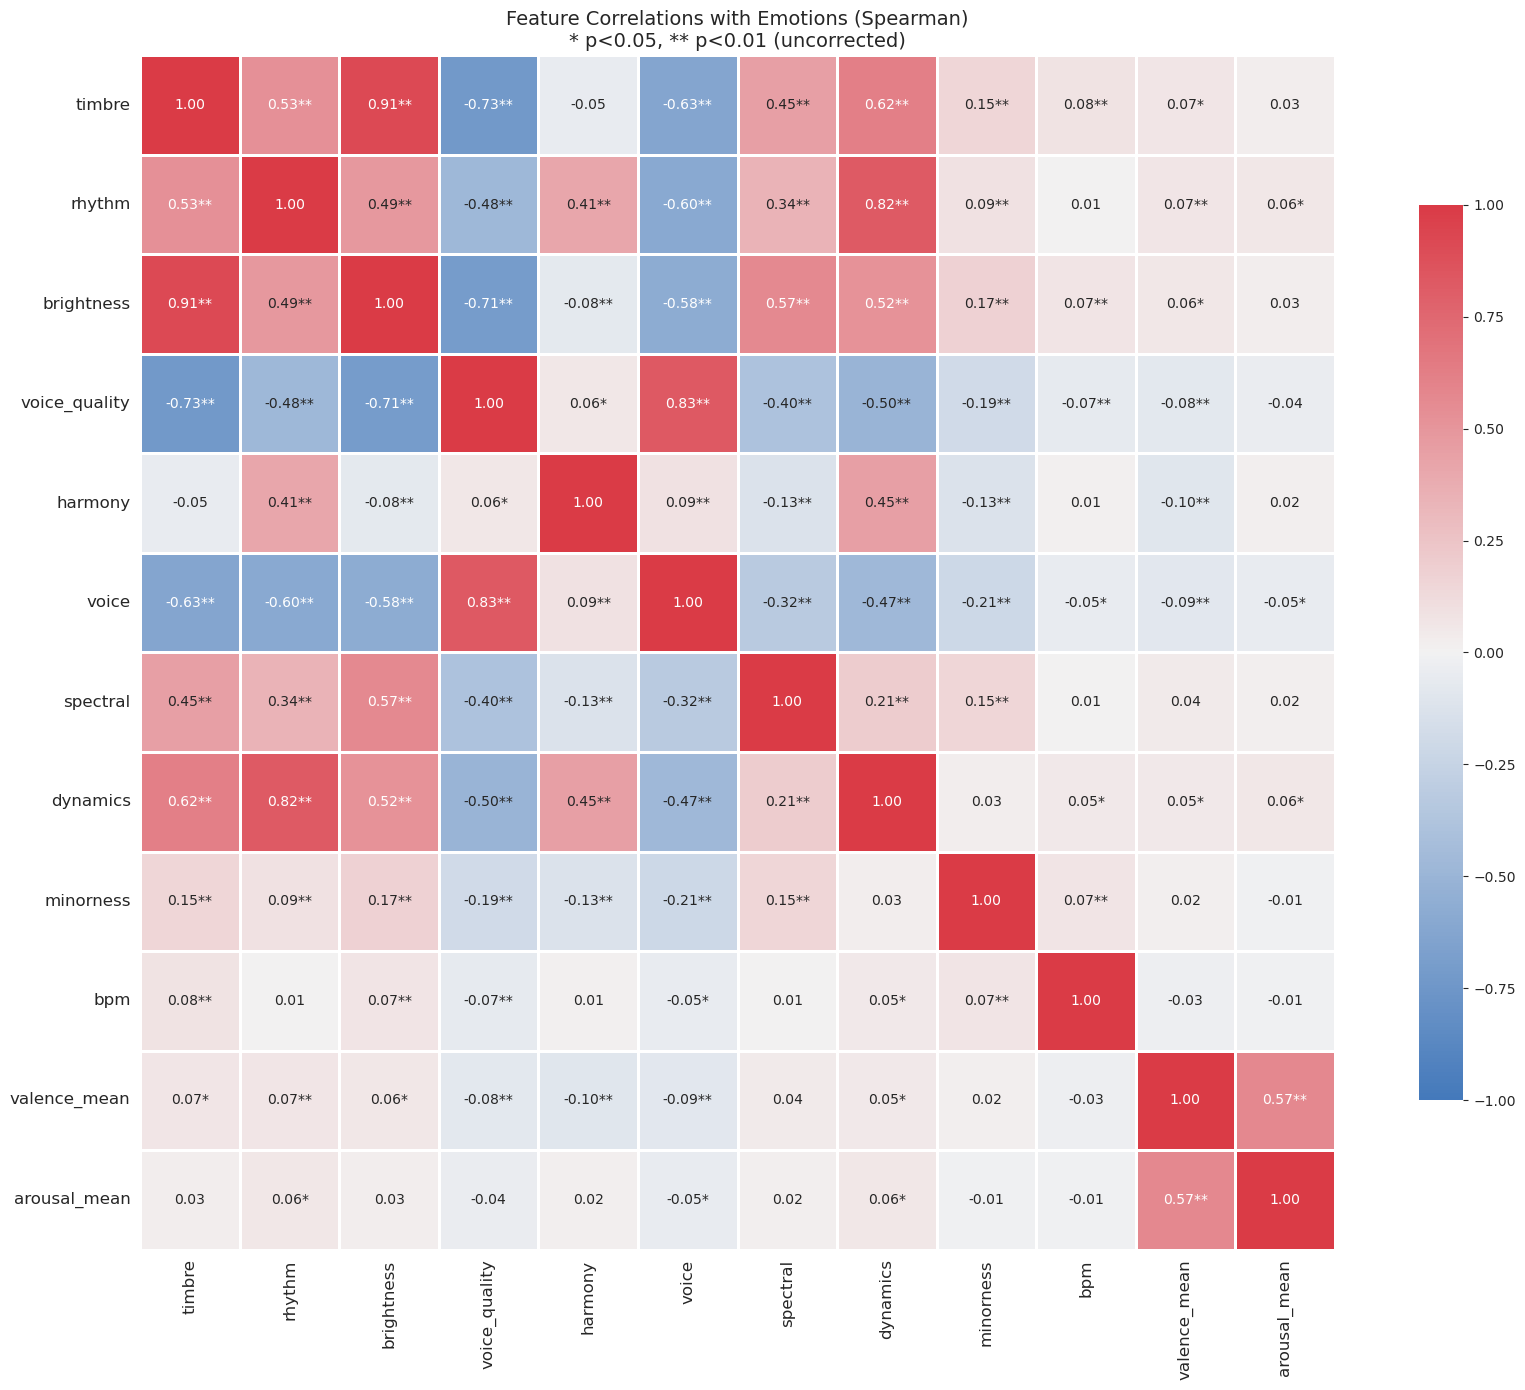


=== Key Findings (uncorrected p-values) ===

Valence Mean:
  - harmony: r=0.101** (weak)
  - voice: r=0.093** (weak)
  - voice_quality: r=0.078** (weak)

Arousal Mean:
  - rhythm: r=0.061* (weak)
  - dynamics: r=0.057* (weak)
  - voice: r=0.054* (weak)


In [139]:
corr_matrix_music = plot_feature_correlations_heatmap(
    df_music_numeric, 
    VIZ_PATH, 
    level='high'
)

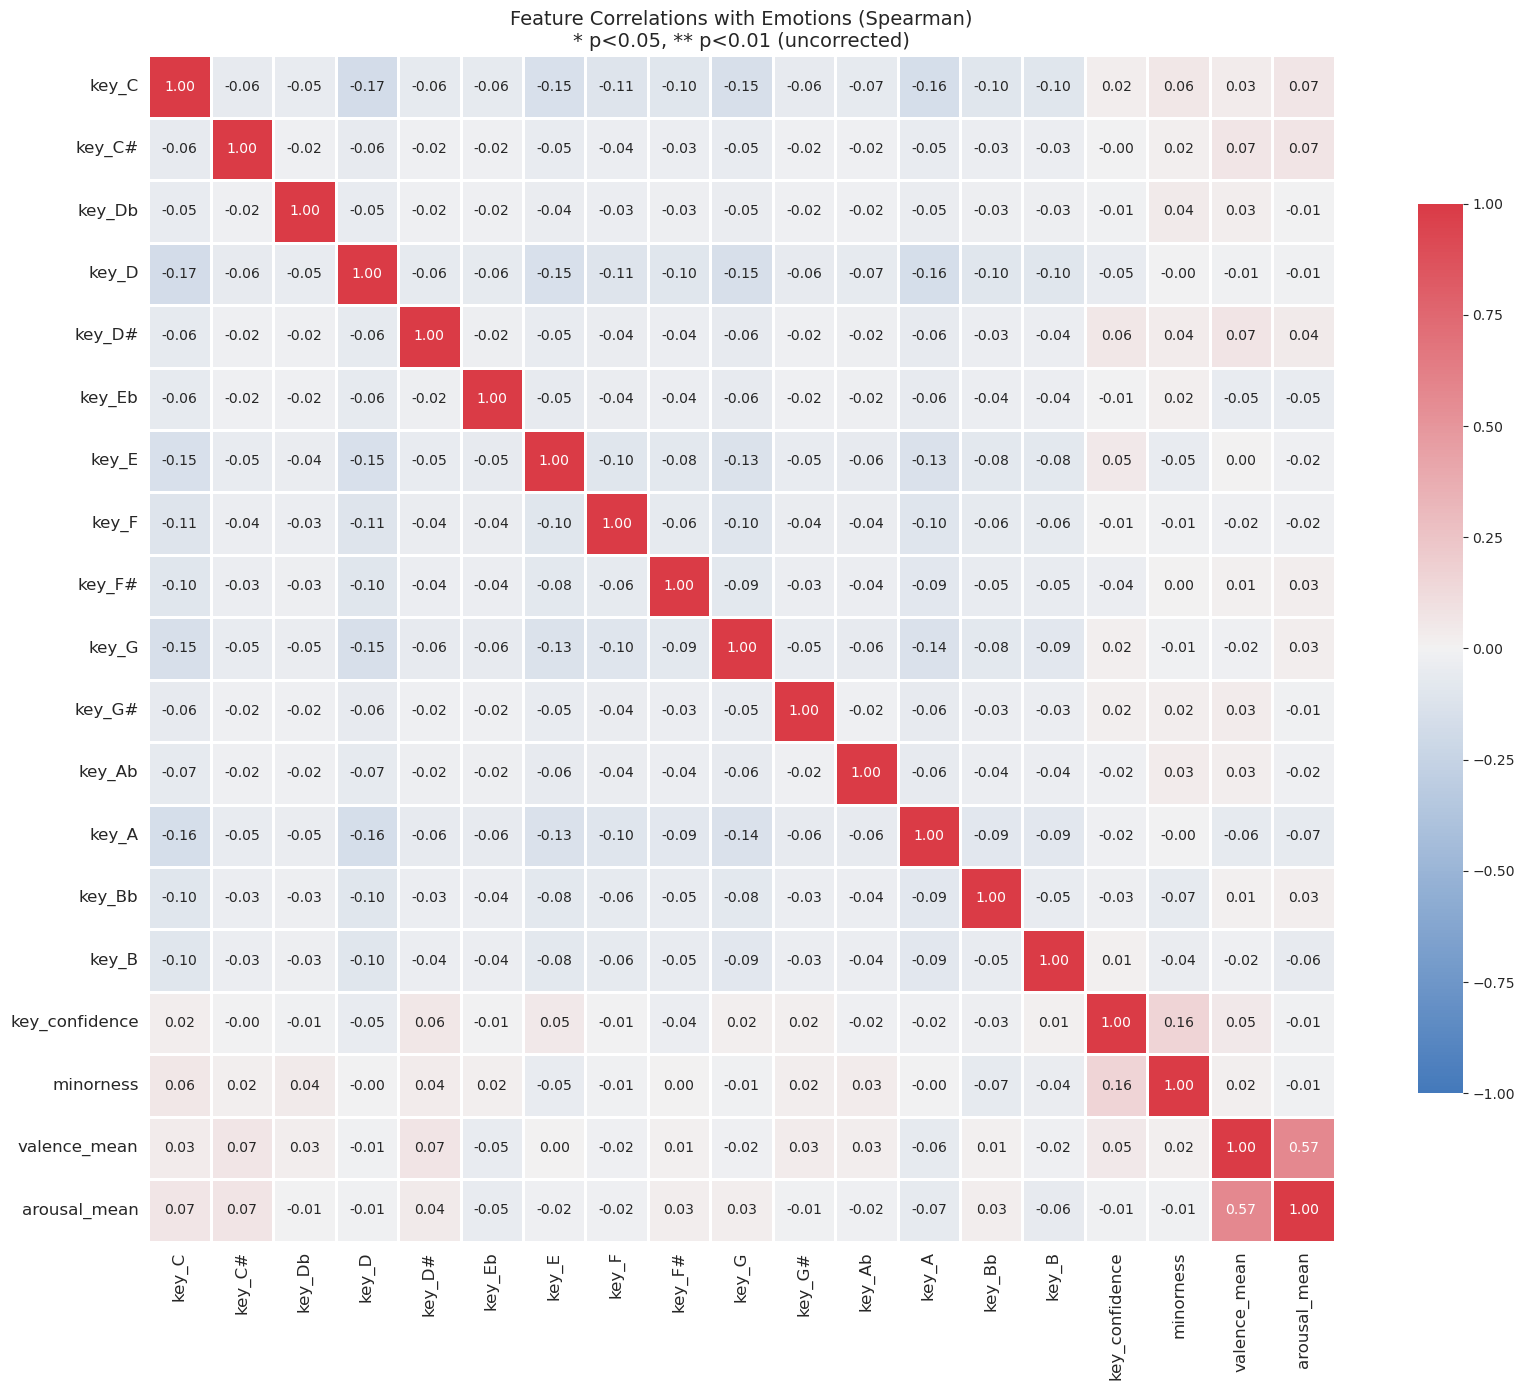


=== Key Findings (uncorrected p-values) ===

Valence Mean:
  - key_D#: r=0.072** (weak)
  - key_C#: r=0.066* (weak)
  - key_A: r=0.064* (weak)

Arousal Mean:
  - key_C#: r=0.072** (weak)
  - key_A: r=0.069* (weak)
  - key_C: r=0.066* (weak)


In [179]:
df_with_targets = pd.concat(
    [key_dummies_percept, 
     df_percept_encoded[['key_confidence','valence_mean', 'arousal_mean', 'minorness']].reset_index(drop=True)],
    axis=1
)

corr_matrix_keys = plot_feature_correlations_heatmap(df_with_targets, VIZ_PATH, level='keys')

### PCA analysis

/home/georgios/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


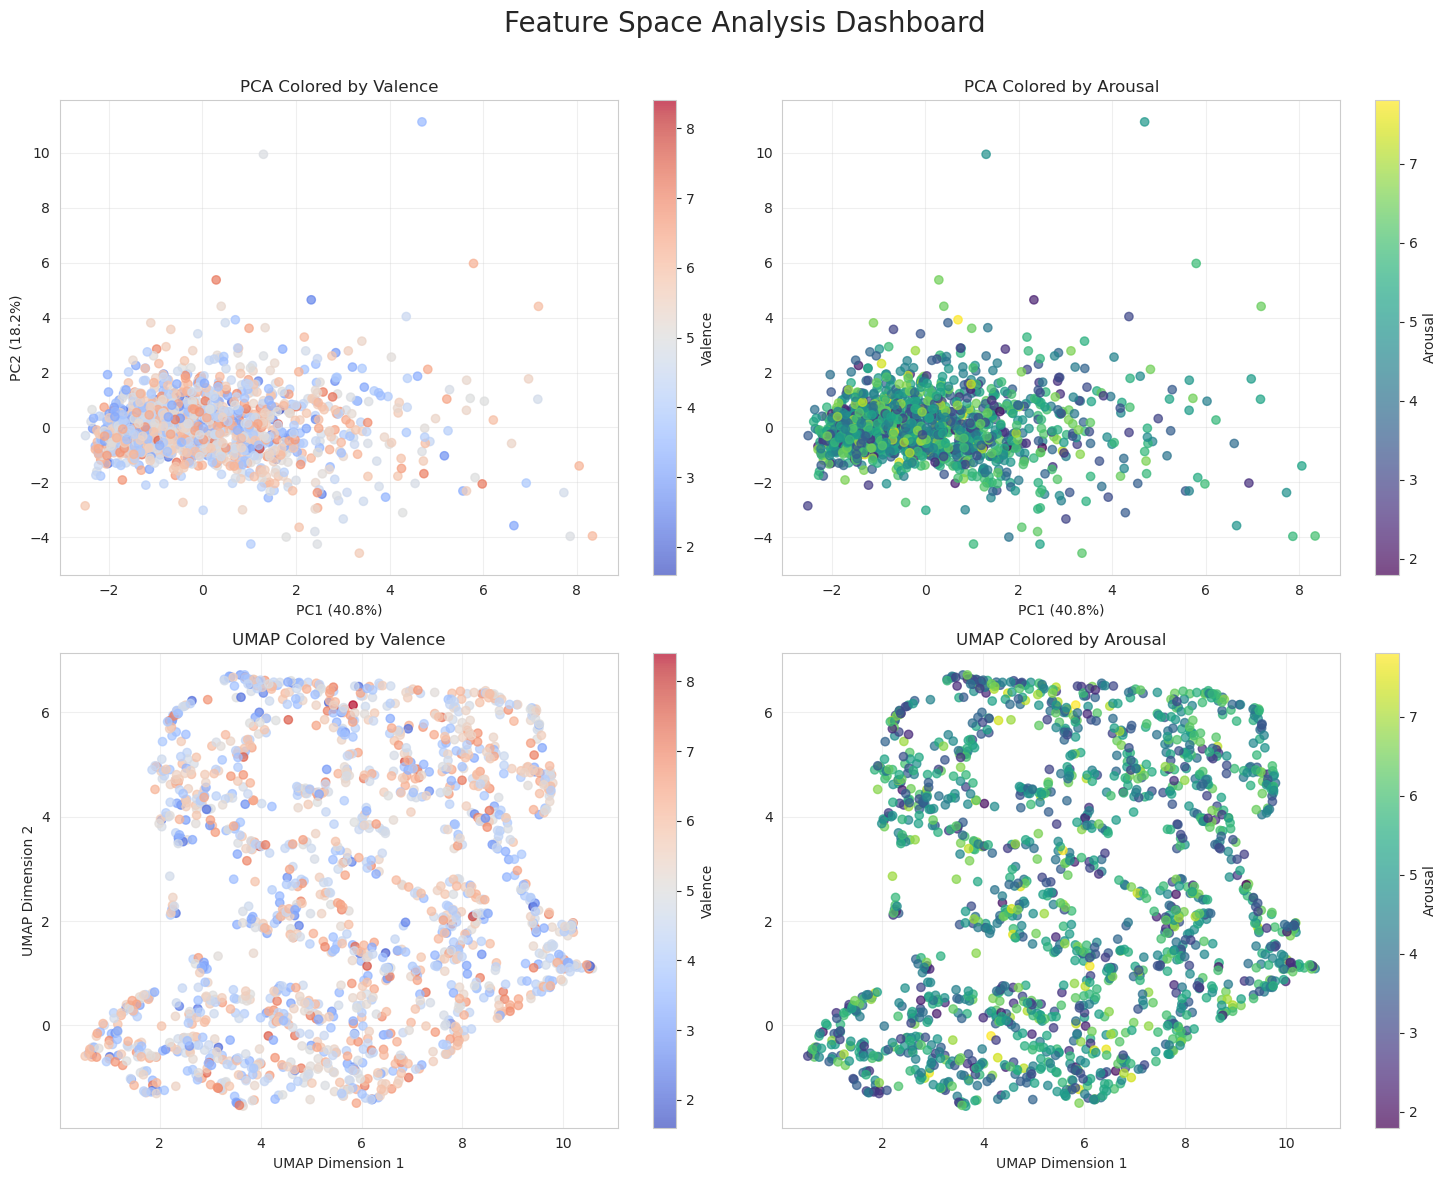

In [141]:
loadings_high = plot_pca_and_umap(df_percept, VIZ_PATH)

/home/georgios/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


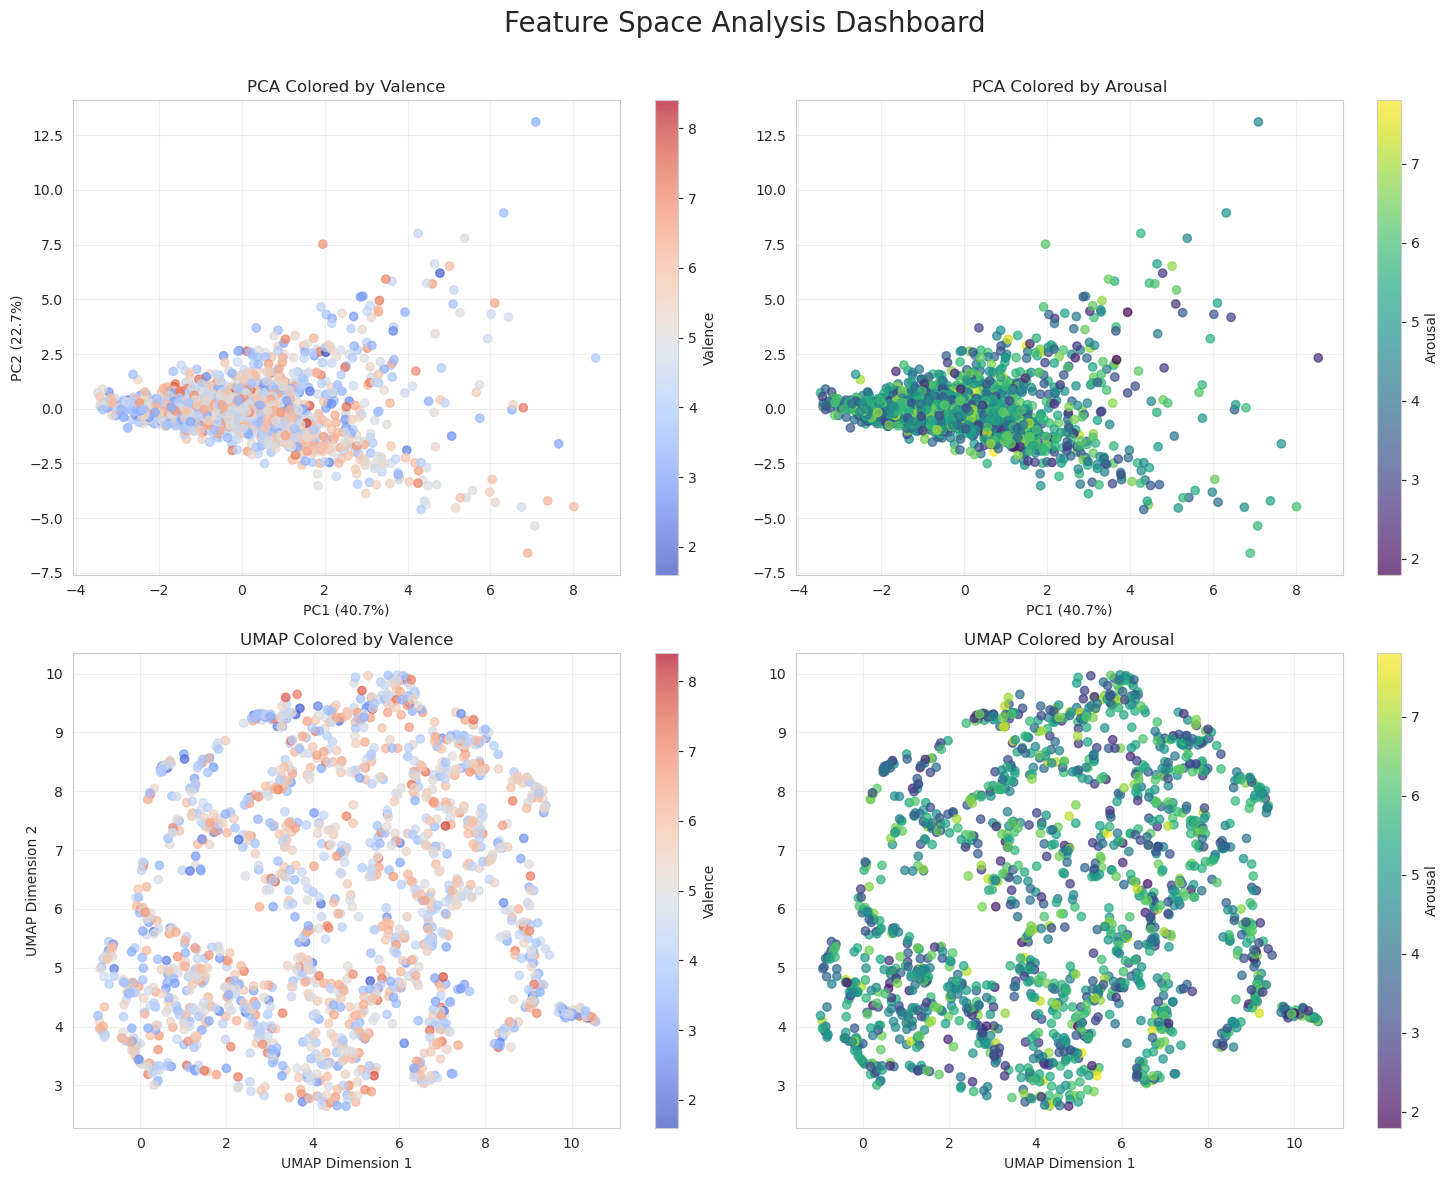

In [142]:
loadings_mid = plot_pca_and_umap(df_music, VIZ_PATH)

In [143]:
per_cluster_pca = pd.read_parquet("../data/processed/features_pca_per_group_3900.parquet")
labels = pd.read_parquet("../data/processed/core_dataset.parquet")
labels = labels.set_index('song_id')
common = per_cluster_pca.index.intersection(labels.index)
print(len(common))
per_cluster_pca = per_cluster_pca.join(labels, how='inner')

1802


/home/georgios/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


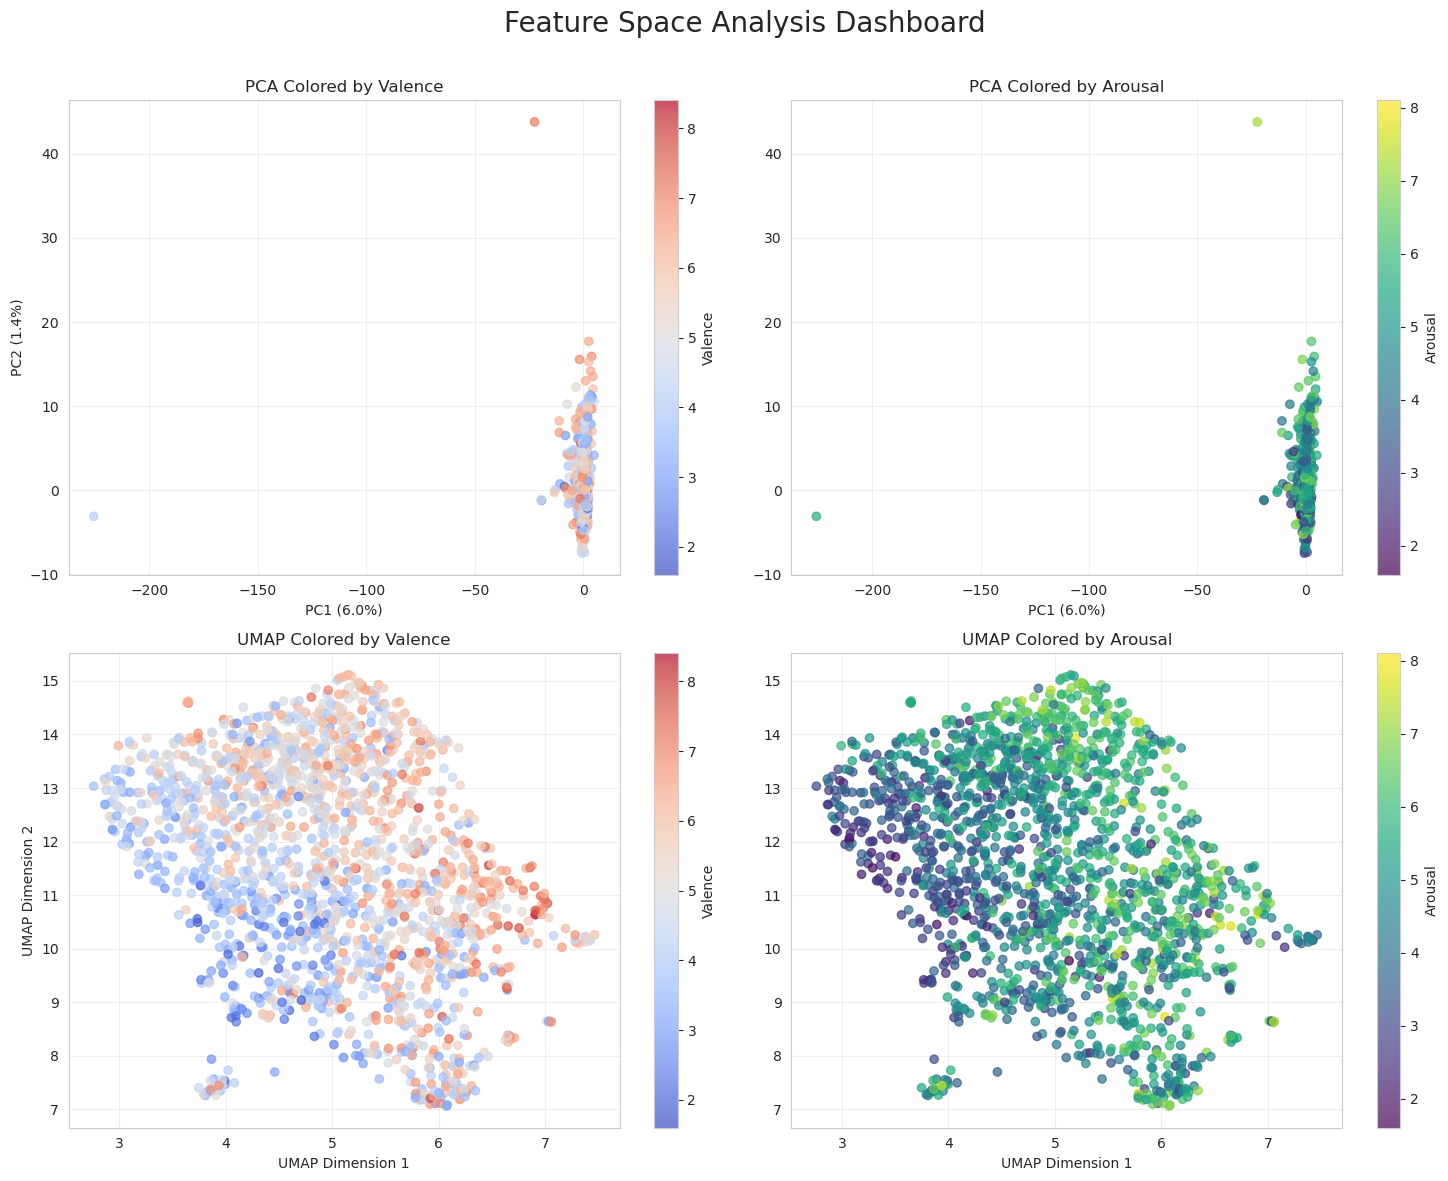

In [144]:
loadings_clpca = plot_pca_and_umap(per_cluster_pca, VIZ_PATH)

In [145]:
from adjustText import adjust_text
all_loadings = {
    "Mid-Level Features": loadings_mid,
    "High-Level Features": loadings_high,
    "PCA-per-Theory-cluster Features": loadings_clpca
}

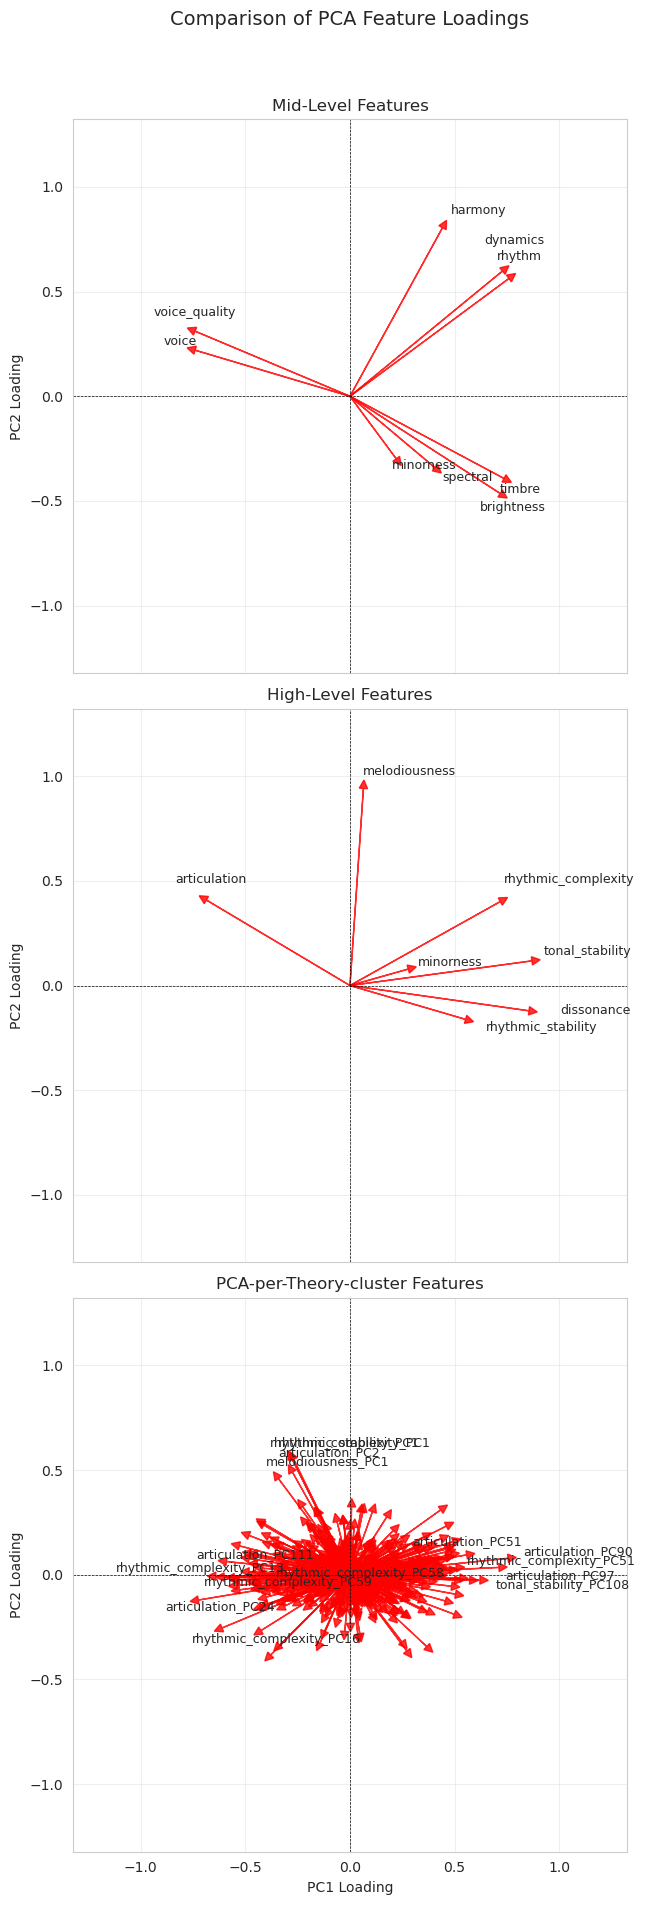

In [178]:
max_val = 0
for df in all_loadings.values():
    max_val = max(max_val, abs(df.values).max())
axis_limit = max_val * 1.4

fig, axes = plt.subplots(3, 1, figsize=(8, 20), sharex=True)
fig.suptitle("Comparison of PCA Feature Loadings", fontsize=14)

for ax, (title, loadings_df) in zip(axes, all_loadings.items()):

    loadings_df['magnitude'] = np.sqrt(loadings_df['PC1']**2 + loadings_df['PC2']**2)
    top_15 = loadings_df.nlargest(15, 'magnitude')
    
    for feature in loadings_df.index:
        ax.arrow(0, 0, loadings_df.loc[feature, 'PC1'], loadings_df.loc[feature, 'PC2'],
                 head_width=0.04, head_length=0.04, fc='red', ec='red', alpha=0.8)

    texts = []
    for feature in top_15.index:
        texts.append(ax.text(loadings_df.loc[feature, 'PC1']*1.2,
                             loadings_df.loc[feature, 'PC2']*1.2,
                             feature, fontsize=9))

    adjust_text(texts, ax=ax)

    ax.set_title(title)
    ax.set_ylabel('PC2 Loading')
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='k', linestyle='--', linewidth=0.5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-axis_limit, axis_limit)
    ax.set_ylim(-axis_limit, axis_limit)

axes[2].set_xlabel('PC1 Loading')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [148]:
# check if per-group approach maintains more dimensions
for dataset_name in ['features_2080', 'features_3900', 'features_decorrelated_2080',"features_decorrelated_3900",
        'features_pca_global_2080', 'features_pca_global_3900', 'features_pca_per_group_2080', 'features_pca_per_group_3900']:
    df = pd.read_parquet(f"../data/processed/{dataset_name}.parquet")
    
    # Quick PCA test
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    
    pca_test = PCA(n_components=0.95)
    pca_test.fit(scaled)
    
    print(f"{dataset_name:30s}: {df.shape[1]:4d} features -> {pca_test.n_components_:3d} PCs (95% var)")

features_2080                 : 2080 features -> 260 PCs (95% var)
features_3900                 : 3900 features -> 350 PCs (95% var)
features_decorrelated_2080    : 1257 features -> 282 PCs (95% var)
features_decorrelated_3900    : 2138 features -> 397 PCs (95% var)
features_pca_global_2080      :  242 features -> 225 PCs (95% var)
features_pca_global_3900      :  317 features -> 291 PCs (95% var)
features_pca_per_group_2080   :  347 features -> 221 PCs (95% var)
features_pca_per_group_3900   :  516 features -> 323 PCs (95% var)


### Feature Mapping Analysis

In [77]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap

In [78]:
from src.aggregate import *
from src.make_dataset.deam_loader import *

In [80]:
# Load data
features_2080 = pd.read_parquet("../data/processed/features_2080.parquet")
hierarchy = pd.read_csv("../data/hierarchy_map.csv")

print(f"Dataset shape: {features_2080.shape}")
print(f"Unique base features: {len(hierarchy)}")

Dataset shape: (1802, 2080)
Unique base features: 260


In [81]:
unique_groups = sorted(hierarchy['perceptual'].unique())

# Generate a list of colors, one for each group
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))
# Create the dictionary mapping group names to colors
color_map = {group: color for group, color in zip(unique_groups, colors)}

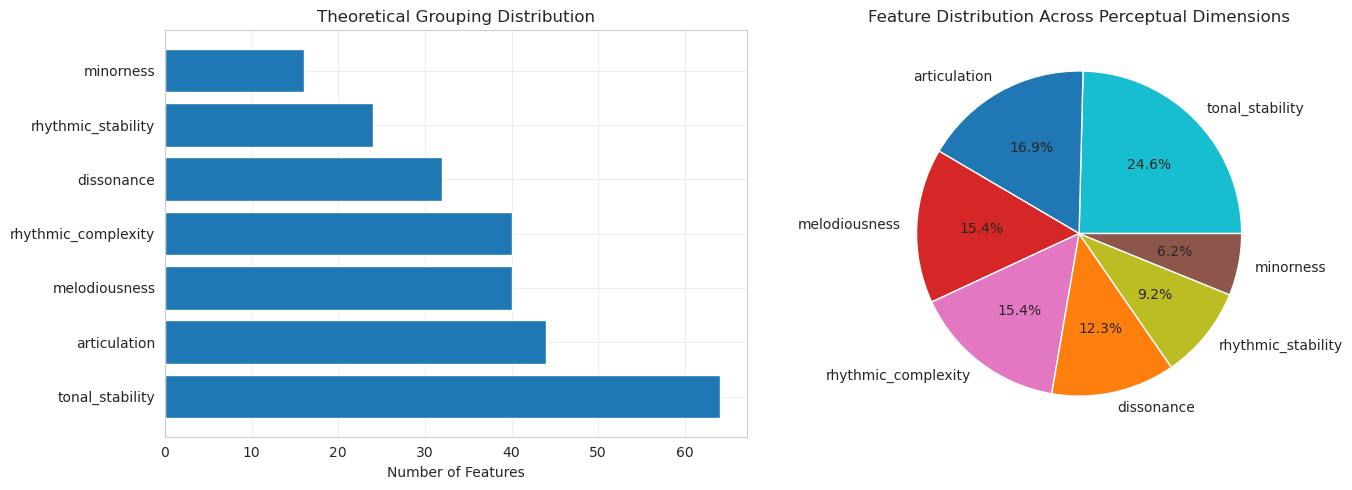

In [82]:
# Analyze theoretical grouping distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of features per group
group_counts = hierarchy['perceptual'].value_counts()
ax1.barh(group_counts.index, group_counts.values)
ax1.set_xlabel('Number of Features')
ax1.set_title('Theoretical Grouping Distribution')
ax1.grid(alpha=0.3)

# Pie chart of proportions
pie_colors = [color_map[label] for label in group_counts.index]

# Pass the colors to the pie chart function
ax2.pie(group_counts.values, labels=group_counts.index, autopct='%1.1f%%', colors=pie_colors)
ax2.set_title('Feature Distribution Across Perceptual Dimensions')

plt.tight_layout()
plt.show()

### Genre correlation

In [35]:
import os
# Load all metadata CSVs
metadata_dir = '../data/raw/metadata_DEAM/metadata'
metadata_files = [f for f in os.listdir(metadata_dir) if f.endswith('.csv')]

metadata_list = [pd.read_csv(os.path.join(metadata_dir, f)) for f in metadata_files]

# concatenate them into one DataFrame
metadata_df = pd.concat(metadata_list, ignore_index=True)

# Merge with the original df on song_id
merged_df = df_core.merge(metadata_df, on='song_id', how='left')  # left join to keep only matching rows

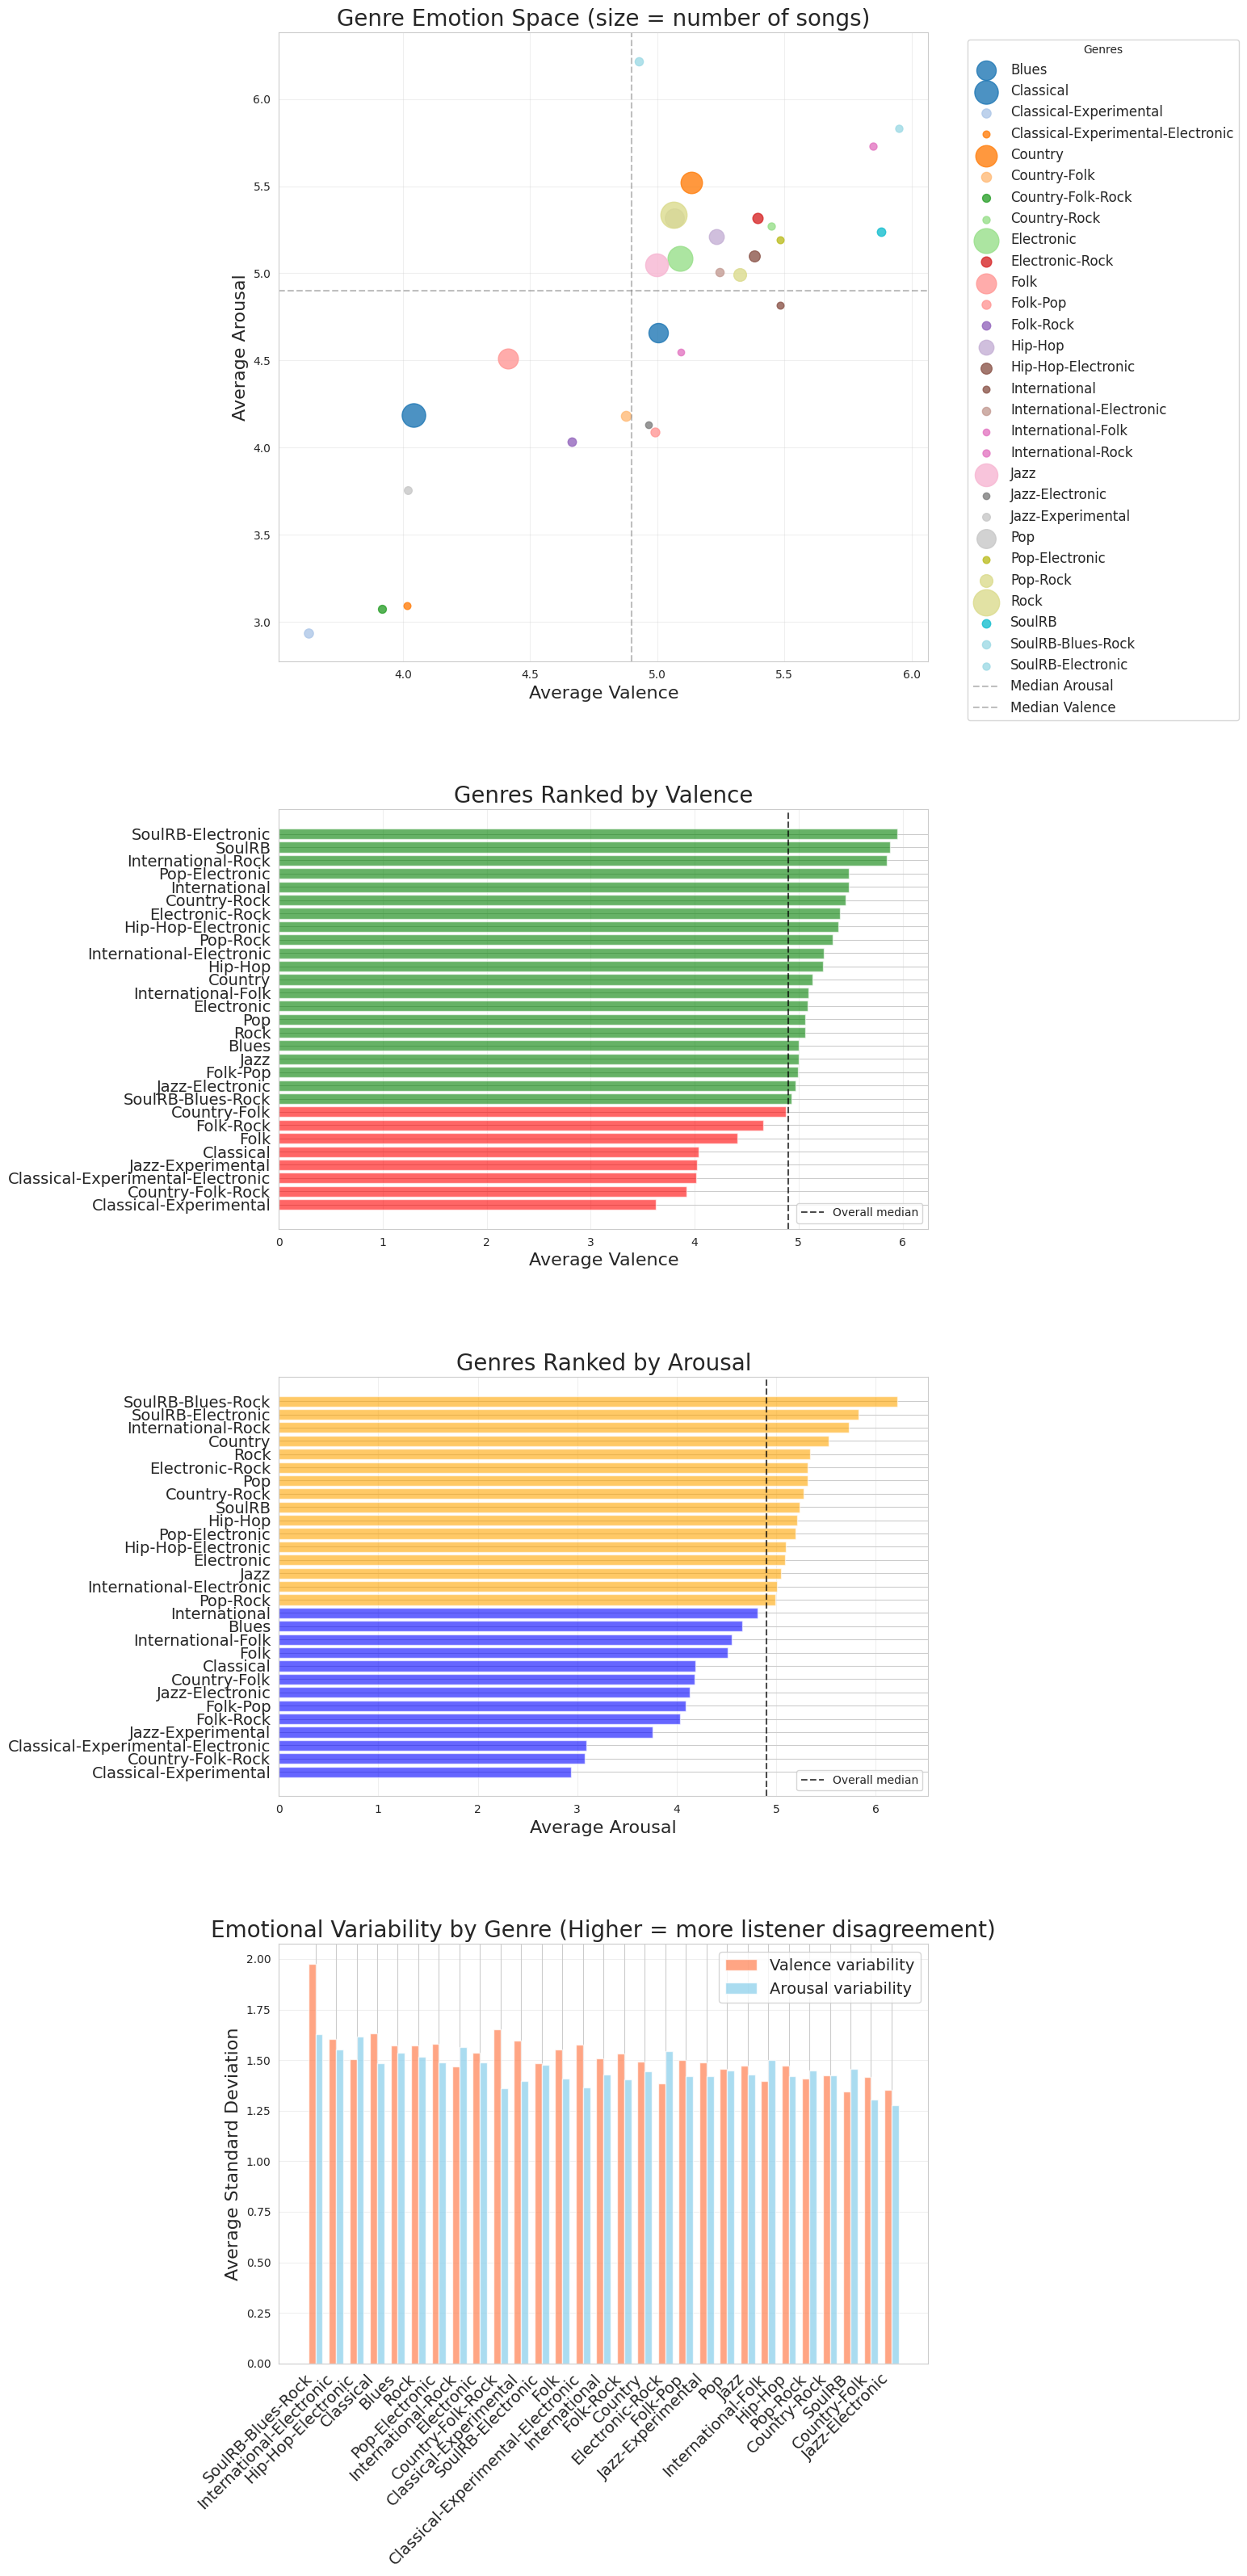

In [66]:
genre_stats, summary = analyze_genre_emotions(df_core, metadata_df, VIZ_PATH)

In [40]:
print("\nMost positive genres (valence):")
print(summary['most_positive_genres'])

print("\nMost energetic genres (arousal):")
print(summary['most_energetic_genres'])

print("\nMost emotionally variable genres (highest disagreement - number is the addition of the standard deviations in annotations for valence and arousal):")
print(summary['most_variable_genres'])


Most positive genres (valence):
primary_genre
SoulRB-Electronic     5.950
SoulRB                5.879
International-Rock    5.850
Name: (valence_mean, mean), dtype: float64

Most energetic genres (arousal):
primary_genre
SoulRB-Blues-Rock     6.217
SoulRB-Electronic     5.829
International-Rock    5.729
Name: (arousal_mean, mean), dtype: float64

Most emotionally variable genres (highest disagreement - number is the addition of the standard deviations in annotations for valence and arousal):
primary_genre
SoulRB-Blues-Rock           3.604
International-Electronic    3.157
Hip-Hop-Electronic          3.119
dtype: float64


### Outliers

In [23]:
valence_outliers = find_emotion_outliers(df_core, metadata_df, 'valence_mean')


=== Valence Mean Outliers ===
Mean: 4.90, Std: 1.17

High valence_mean (> 7.25):
  • 	RL Got Soul	 - The Jon Spencer Blues Explosion	 (	Blues	): 7.90
  • 	Ramblin' Rose	 - Barrence Whitfield and The Savages	 (	Blues	): 7.30
  • 	Bip Bop Bip	 - Barrence Whitfield and The Savages	 (	Blues	): 8.40
  • 	Wine Wine Wine	 - Stompin' Riff Raffs	 (	Country	): 7.60
  • 	Mochi	 - LE CLUB DES CHATS	 (	Country	): 7.70

Low valence_mean (< 2.56):
  • 	Nine	 - Marcel Pequel	 (	Classical	): 2.40
  • 	5 00 AM	 - Peter Rudenko	 (	Classical	): 2.10
  • 	Black Coffee	 - Jody Pou	 (	Classical	): 2.40
  • 	That Kid in Fourth Grade Who Really Liked the Denver Broncos	 - Chris Zabriskie	 (	Classical	): 2.10
  • 	Six	 - Marcel Pequel	 (	Classical	): 2.40

High variability in valence:
  • Black Hole - Mike Rep and the Quotas: std=2.90
  • Only The Wrong Survive - Vialka: std=2.84
  • Green Turning Light - Sound Of Ground: std=2.71
  • Eyes - I Have Clones: std=2.71
  • 	Crack in Time	 - Stickfigure	: std=2.70


In [24]:
arousal_outliers = find_emotion_outliers(df_core, metadata_df, 'arousal_mean')


=== Arousal Mean Outliers ===
Mean: 4.81, Std: 1.28

High arousal_mean (> 7.38):
  • 	Bip Bop Bip	 - Barrence Whitfield and The Savages	 (	Blues	): 7.80
  • 	Original Rags (1900 piano roll)  - Scott Joplin	 (	Country	): 7.40
  • 	Horror Show	 - Stompin' Riff Raffs	 (	Country	): 7.40
  • 	Scotland the Brave	 - Shake That Little Foot	 (	Country	): 7.50
  • 	I Wanna Say Hello	 - Pee Wee King	 (	Country	): 7.60

Low arousal_mean (< 2.25):
  • 	Untitled 05	 - Mountain Cult	 (	Blues	): 2.10
  • 	Aleph	 - Ophir Ilzetzki	 (	Classical	): 2.20
  • 	Ease	 - Andrew Bisset-Cultural Dis	 (	Classical	): 2.20
  • 	Sinfonia di Violoncello e AM RadioFinitura - Joe Merolla	 (	Classical	): 2.20
  • 	Maia	 - Kreng	 (	Jazz	): 1.60

High variability in arousal:
  • II - Angels in America: std=2.59
  • 	RL Got Soul	 - The Jon Spencer Blues Explosion	: std=2.53
  • 	Memories Of Thailand (Beat Doctor's 'stuck in Britain' remix)	 - Risey	: std=2.52
  • Lover - Break The Bans: std=2.49
  • Vietnam - Here Comes A